### **ПРАКТИЧЕСКОЕ ЗАДАНИЕ**

Разобраться с моделькой перевода как она устроена.

Запустить для перевода с русского на английский (при желании можно взять другие пары языков) два варианта с вниманием и без внимания
оценить качество насколько корректно переводит (для теста отобрать примеры с увеличением длины текста).

(так как оценка визуальная достаточно 20-ти примеров в тестовой выборке).

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split
import unicodedata
import re
import numpy as np
import os
import io
import time

### **МАШИННЫЙ ПЕРЕВОД СТАНДАРТНЫЙ**

In [2]:
# Загружаем датасет

!wget http://www.manythings.org/anki/rus-eng.zip
!mkdir rus-eng
!unzip rus-eng.zip -d rus-eng/
!ls /content/rus-eng/ -lah

path_to_file = "/content/rus-eng/rus.txt"

--2022-09-21 13:06:14--  http://www.manythings.org/anki/rus-eng.zip
Resolving www.manythings.org (www.manythings.org)... 173.254.30.110
Connecting to www.manythings.org (www.manythings.org)|173.254.30.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15011848 (14M) [application/zip]
Saving to: ‘rus-eng.zip’

rus-eng.zip         100%[===================>]  14.32M  23.9MB/s    in 0.6s    

2022-09-21 13:06:15 (23.9 MB/s) - ‘rus-eng.zip’ saved [15011848/15011848]

Archive:  rus-eng.zip
  inflating: rus-eng/rus.txt         
  inflating: rus-eng/_about.txt      
total 72M
drwxr-xr-x 2 root root 4.0K Sep 21 13:06 .
drwxr-xr-x 1 root root 4.0K Sep 21 13:06 ..
-rw-r--r-- 1 root root 1.5K Sep  6 03:10 _about.txt
-rw-r--r-- 1 root root  72M Sep  6 03:10 rus.txt


In [3]:
# Функция предобработки текста

def preprocess_sentence(w):
  w = w.lower().strip()

  # creating a space between a word and the punctuation following it
  # eg: "he is a boy." => "he is a boy ."
  # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
  w = re.sub(r"([?.!,])", r" \1 ", w)
  w = re.sub(r'[" "]+', " ", w)

  # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
  w = re.sub(r"[^a-zA-Zа-яА-Я?.!,']+", " ", w)

  w = w.strip()

  # adding a start and an end token to the sentence
  # so that the model know when to start and stop predicting.
  w = '<start> ' + w + ' <end>'
  return w

In [4]:
# Пример на английском языке

preprocess_sentence("I can't go.")

"<start> i can't go . <end>"

In [5]:
# Пример на русском языке

preprocess_sentence("Я ем Пироженку!")

'<start> я ем пироженку ! <end>'

In [6]:
# Посмотрим на датасет

lines = io.open(path_to_file, encoding='UTF-8').read().strip().split('\n')
lines[:15]

['Go.\tМарш!\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #1159202 (shanghainese)',
 'Go.\tИди.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898247 (marafon)',
 'Go.\tИдите.\tCC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #5898250 (marafon)',
 'Hi.\tЗдравствуйте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #402127 (odexed)',
 'Hi.\tПривет!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #466968 (katjka)',
 'Hi.\tХай.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #467233 (timsa)',
 'Hi.\tЗдрасте.\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3803577 (marafon)',
 'Hi.\tЗдоро́во!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #3854188 (marafon)',
 'Hi.\tПриветик!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #7234283 (marafon)',
 'Run!\tБеги!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #1569978 (Biga)',
 'Run!\tБегите!\tCC-BY 2.0 (France)

In [7]:
# Функция создания пар англисйкий - русский

# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENG, RUS]

def create_dataset(path, num_examples):
  lines = io.open(path, encoding='UTF-8').read().strip().split('\n')
  word_pairs = [[preprocess_sentence(w) for w in l.split('\t')[:2]]  for l in lines[:num_examples]]
  return zip(*word_pairs)

In [8]:
# Поделим английский и русский языки на 2 набора данных

en, ru = create_dataset(path_to_file, None)
print(en[10])
print(ru[10])

<start> run ! <end>
<start> бегите ! <end>


In [9]:
# Функция токенизации

def tokenize(lang):
  lang_tokenizer = tf.keras.preprocessing.text.Tokenizer(filters='')
  lang_tokenizer.fit_on_texts(lang)
  tensor = lang_tokenizer.texts_to_sequences(lang)
  tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')
  return tensor, lang_tokenizer


# Функция создания токенизированного датасета

def load_dataset(path, num_examples=None):
  # creating cleaned input, output pairs
  targ_lang, inp_lang = create_dataset(path, num_examples)
  print(targ_lang)
  input_tensor, inp_lang_tokenizer = tokenize(inp_lang)
  target_tensor, targ_lang_tokenizer = tokenize(targ_lang)
  return input_tensor, target_tensor, inp_lang_tokenizer, targ_lang_tokenizer

In [10]:
# Посмотрим на длину датасета

len(en), len(ru)

(451436, 451436)

In [11]:
# Try experimenting with the size of that dataset
num_examples = 100000
input_tensor, target_tensor, inp_lang, targ_lang = load_dataset(path_to_file, num_examples)

# Calculate max_length of the target tensors
max_length_targ, max_length_inp = target_tensor.shape[1], input_tensor.shape[1]

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [12]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
print(len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val))

80000 80000 20000 20000


In [13]:
# Функция конвертации индексов в слова

def convert(lang, tensor):
  for t in tensor:
    if t!=0:
      print ("%d ----> %s" % (t, lang.index_word[t]))

In [14]:
print ("Input Language; index to word mapping")
convert(inp_lang, input_tensor_train[0])
print ()
print ("Target Language; index to word mapping")
convert(targ_lang, target_tensor_train[0])

Input Language; index to word mapping
1 ----> <start>
25 ----> тому
64 ----> нужно
980 ----> ружь
3 ----> .
2 ----> <end>

Target Language; index to word mapping
1 ----> <start>
5 ----> tom
239 ----> needs
9 ----> a
506 ----> gun
3 ----> .
2 ----> <end>


In [15]:
# Зададим параметры для нейросети и сформируем тренировочный датасет

BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
steps_per_epoch = len(input_tensor_train)//BATCH_SIZE
embedding_dim = 300
units = 1024
vocab_inp_size = len(inp_lang.word_index)+1
vocab_tar_size = len(targ_lang.word_index)+1

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

In [16]:
example_input_batch, example_target_batch = next(iter(dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 15]), TensorShape([64, 11]))

In [17]:
# Создадим класс Энкодера

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    # self.gru = tf.keras.layers.GRU(self.enc_units,
    #                                return_sequences=False,
    #                                return_state=True,
    #                                recurrent_initializer='glorot_uniform')
    
    self.bdgru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                                                    return_sequences=False,
                                                                    return_state=True,
                                                                    recurrent_initializer='glorot_uniform'))
    

  def call(self, x, hidden):
    x = self.embedding(x)
    # output, state = self.gru(x, initial_state=hidden)
    output, state_1, state_2 = self.bdgru(x, initial_state=hidden)
    return state_1, state_2

  def initialize_hidden_state(self):
    # return tf.zeros((self.batch_sz, self.enc_units))
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)]

In [18]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_hidden_1, sample_hidden_2 = encoder(example_input_batch, sample_hidden)
# print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state_1 shape: (batch size, units) {}'.format(sample_hidden_1.shape))
print ('Encoder Hidden state_2 shape: (batch size, units) {}'.format(sample_hidden_2.shape))

Encoder Hidden state_1 shape: (batch size, units) (64, 1024)
Encoder Hidden state_2 shape: (batch size, units) (64, 1024)


In [19]:
# Создадим класс Декодера

class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.gru2 = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    self.fc = tf.keras.layers.Dense(vocab_size)

  def call(self, x, hidden_1, hidden_2):
    # enc_output shape == (batch_size, max_length, hidden_size)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x, initial_state=hidden_1)
    output, state2 = self.gru2(output, initial_state=hidden_2)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state2

In [20]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

decoder_sample_x, decoder_sample_h = decoder(tf.random.uniform((BATCH_SIZE, 1)), sample_hidden_1, sample_hidden_2)
decoder_sample_x.shape, decoder_sample_h.shape

(TensorShape([64, 7335]), TensorShape([64, 1024]))

In [21]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     multiple                  2200500   
                                                                 
 gru_1 (GRU)                 multiple                  4073472   
                                                                 
 gru_2 (GRU)                 multiple                  6297600   
                                                                 
 dense (Dense)               multiple                  7518375   
                                                                 
Total params: 20,089,947
Trainable params: 20,089,947
Non-trainable params: 0
_________________________________________________________________


In [22]:
# Зададим оптимизатор и функцию потерь

optimizer = tf.keras.optimizers.Adam()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [23]:
# Будем сохранять чек-пойнты

checkpoint_dir = './training_nmt_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [24]:
@tf.function
def train_step(inp, targ, enc_hidden):
# Функция обучения

  loss = 0

  with tf.GradientTape() as tape:
    enc_hidden_1, enc_hidden_2 = encoder(inp, enc_hidden)
    dec_hidden_1 = enc_hidden_1
    dec_hidden_2 = enc_hidden_2
    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden = decoder(dec_input, dec_hidden_1, dec_hidden_2)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  variables = encoder.trainable_variables + decoder.trainable_variables
  gradients = tape.gradient(loss, variables)
  optimizer.apply_gradients(zip(gradients, variables))
  return batch_loss

In [25]:
# Произведем обучение модели на данных

EPOCHS = 60

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss.numpy()))
  
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.5894
Epoch 1 Batch 100 Loss 2.3490
Epoch 1 Batch 200 Loss 2.1730
Epoch 1 Batch 300 Loss 1.9043
Epoch 1 Batch 400 Loss 1.6996
Epoch 1 Batch 500 Loss 1.4888
Epoch 1 Batch 600 Loss 1.3453
Epoch 1 Batch 700 Loss 1.3142
Epoch 1 Batch 800 Loss 0.9915
Epoch 1 Batch 900 Loss 1.1174
Epoch 1 Batch 1000 Loss 1.0676
Epoch 1 Batch 1100 Loss 0.9898
Epoch 1 Batch 1200 Loss 1.0468
Epoch 1 Loss 1.5014
Time taken for 1 epoch 117.40915107727051 sec

Epoch 2 Batch 0 Loss 0.7099
Epoch 2 Batch 100 Loss 0.8167
Epoch 2 Batch 200 Loss 0.6951
Epoch 2 Batch 300 Loss 0.7835
Epoch 2 Batch 400 Loss 0.7002
Epoch 2 Batch 500 Loss 0.5207
Epoch 2 Batch 600 Loss 0.6903
Epoch 2 Batch 700 Loss 0.6205
Epoch 2 Batch 800 Loss 0.6040
Epoch 2 Batch 900 Loss 0.5171
Epoch 2 Batch 1000 Loss 0.6037
Epoch 2 Batch 1100 Loss 0.6406
Epoch 2 Batch 1200 Loss 0.6794
Epoch 2 Loss 0.6731
Time taken for 1 epoch 100.87126421928406 sec

Epoch 3 Batch 0 Loss 0.4125
Epoch 3 Batch 100 Loss 0.4468
Epoch 3 Batch 200 Loss 0.4

In [ ]:
# !pip install pymorphy2

In [ ]:
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

# Функция для предсказания перевода

def evaluate(sentence):
  # attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  # inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]
  # inputs = [inp_lang.word_index[i] if i in inp_lang.word_index else 0 for i in sentence.split(' ')]

  inputs = []
  for i in sentence.split(' '):
    if i in inp_lang.word_index:
      inputs.append(inp_lang.word_index[i])
    else:
      try:
        inputs.append(inp_lang.word_index[morph.parse(i)[0].normal_form])
      except:
        # inputs.append(0)
        continue


  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  # hidden = [tf.zeros((1, units))]
  hidden = [tf.zeros((1, units)) for i in range(2)]
  enc_hidden_1, enc_hidden_2 = encoder(inputs, hidden)

  dec_hidden_1 = enc_hidden_1
  dec_hidden_2 = enc_hidden_2
  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden = decoder(dec_input, dec_hidden_1, dec_hidden_2)

    # storing the attention weights to plot later on
    predicted_id = tf.argmax(predictions[0]).numpy()
    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence


# Функция вывода перевода
def translate(sentence):
  result, sentence = evaluate(sentence)

  # print('Input: %s' % (sentence))
  # print('Predicted translation: {}'.format(result))
  print(sentence[8:-5])
  print(result[:-7])
  print()

In [30]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [31]:
translate('Привет!')
translate('Небо.')
translate('Зеленое яблоко.')
translate('Красивая газета.')
translate('Меня зовут Юля.')
translate('Нужно взять ластик.')
translate('Сегодня хорошая погода.')
translate('Попробуй сделать это.')
translate('Как проехать до аптеки?')
translate('Вы бывали в Испании?')
translate('Я люблю, когда идет снег.')
translate('Чтобы жить, нужно кушать.')
translate('Откуда у него велосипед?')
translate('Алеша, выходи поиграть в мяч!')
translate('Вы часто готовите сладкие булочки?')
translate('Он сходил в магазин и купил молоко.')
translate('Слово не воробей, вылетит — не поймаешь')
translate('Хочу провести следующий Новый год за городом.')
translate('За окном бушует ураган, довольно опасно выходить на улицу.')
translate('Зачем некоторые люди употребляют алкоголь и потом смеются?')
translate('Я люблю рисовать пастелью различные картины: цветы, животных, пейзажи.')
translate('Скоро я поеду в другой город смотреть на северное сияние и больших плавающих китов.')
translate('Она каждое утро делает макияж, завтракает, едет на метро, чтобы снова работать в поте лица.')

привет ! 
hi .

небо . 
the sky is lying .

зеленое яблоко . 
the apple is an apple is an apple is an

красивая газета . 
this is pretty .

меня зовут юля . 
my name .

нужно взять ластик . 
take a wild .

сегодня хорошая погода . 
the weather .

попробуй сделать это . 
try and make this .

как проехать до аптеки ? 
how is the town ?

вы бывали в испании ? 
were you in trying in trying in trying in try

я люблю , когда идет снег . 
i like snow .

чтобы жить , нужно кушать . 
to eat .

откуда у него велосипед ? 
what's mary's bicycle ?

алеша , выходи поиграть в мяч ! 
come playing at the keys .

вы часто готовите сладкие булочки ? 
do you bake often ?

он сходил в магазин и купил молоко . 
he bought milk .

слово не воробей , вылетит не поймаешь 
i wish not like to say no word didn't 

хочу провести следующий новый год за городом . 
i want a city .

за окном бушует ураган , довольно опасно выходить на улицу . 
way is out .

зачем некоторые люди употребляют алкоголь и потом смеются ? 
w

**Из нововведений:**

1. Использование двунаправленного RNN в Энкодере.
2. Добавление слоя RNN в Декодере.
3. Обработка случая, когда в словаре нет слова, которое нужно перевести. Слово проходит лемматизацию и снова осуществляется поиск по словарю, в противном случае ставится ноль (также был эксперимент, когда слово не учитывается вообще).
4. Увеличено количество эпох до 60.

**Вывод:**

Перевод довольно плохой, несмотря на 60 эпох. В маленьких фразах еще что-то угадывает, большие фразы совершенно не воспринимает.

### **МАШИННЫЙ ПЕРЕВОД С БЛОКОМ ВНИМАНИЯ**

In [32]:
# Создадим класс Энкодера

class Encoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    
    self.bdgru = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(self.enc_units,
                                                                    return_sequences=True,
                                                                    return_state=True,
                                                                    recurrent_initializer='glorot_uniform'))
    

  def call(self, x, hidden):
    x = self.embedding(x)
    output, state_1, state_2 = self.bdgru(x, initial_state=hidden)
    return output, state_1, state_2

  def initialize_hidden_state(self):
    return [tf.zeros((self.batch_sz, self.enc_units)) for i in range(2)]

In [33]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
sample_hidden = encoder.initialize_hidden_state()
sample_output, sample_hidden_1, sample_hidden_2 = encoder(example_input_batch, sample_hidden)
print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state_1 shape: (batch size, units) {}'.format(sample_hidden_1.shape))
print ('Encoder Hidden state_2 shape: (batch size, units) {}'.format(sample_hidden_2.shape))

Encoder output shape: (batch size, sequence length, units) (64, 15, 2048)
Encoder Hidden state_1 shape: (batch size, units) (64, 1024)
Encoder Hidden state_2 shape: (batch size, units) (64, 1024)


In [34]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, query_2, values):
    # query hidden state shape == (batch_size, hidden size)
    # query_with_time_axis shape == (batch_size, 1, hidden size)
    # values shape == (batch_size, max_len, hidden size)
    # we are doing this to broadcast addition along the time axis to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)
    query_with_time_axis_2 = tf.expand_dims(query_2, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(query_with_time_axis) + self.W1(query_with_time_axis_2) + self.W2(values)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [35]:
attention_layer = BahdanauAttention(10)
attention_result, attention_weights = attention_layer(sample_hidden_1, sample_hidden_2, sample_output)

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

Attention result shape: (batch size, units) (64, 2048)
Attention weights shape: (batch_size, sequence_length, 1) (64, 15, 1)


In [36]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = BahdanauAttention(self.dec_units)

  def call(self, x, hidden, hidden_2, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, hidden_2, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)

    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [37]:
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

sample_decoder_output, _, _ = decoder(tf.random.uniform((BATCH_SIZE, 1)),
                                      sample_hidden_1, sample_hidden_2, sample_output)

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))

Decoder output shape: (batch_size, vocab size) (64, 7335)


In [38]:
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

In [39]:
checkpoint_dir = './training_attention_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

In [40]:
@tf.function
def train_step(inp, targ, enc_hidden):
  loss = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden_1, enc_hidden_2 = encoder(inp, enc_hidden)

    dec_hidden_1 = enc_hidden_1
    dec_hidden_2 = enc_hidden_2

    dec_input = tf.expand_dims([targ_lang.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden_1, dec_hidden_2, enc_output)

      loss += loss_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))

  variables = encoder.trainable_variables + decoder.trainable_variables

  gradients = tape.gradient(loss, variables)

  optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss

In [41]:
EPOCHS = 60

for epoch in range(EPOCHS):
  start = time.time()

  enc_hidden = encoder.initialize_hidden_state()
  total_loss = 0

  for (batch, (inp, targ)) in enumerate(dataset.take(steps_per_epoch)):
    batch_loss = train_step(inp, targ, enc_hidden)
    total_loss += batch_loss

    if batch % 100 == 0:
      print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                   batch,
                                                   batch_loss.numpy()))
  # saving (checkpoint) the model every 2 epochs
  if (epoch + 1) % 2 == 0:
    checkpoint.save(file_prefix = checkpoint_prefix)

  print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                      total_loss / steps_per_epoch))
  print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 4.7916
Epoch 1 Batch 100 Loss 2.1615
Epoch 1 Batch 200 Loss 1.8583
Epoch 1 Batch 300 Loss 1.6508
Epoch 1 Batch 400 Loss 1.6422
Epoch 1 Batch 500 Loss 1.4263
Epoch 1 Batch 600 Loss 1.4426
Epoch 1 Batch 700 Loss 1.3605
Epoch 1 Batch 800 Loss 1.1140
Epoch 1 Batch 900 Loss 1.1671
Epoch 1 Batch 1000 Loss 1.1226
Epoch 1 Batch 1100 Loss 1.0971
Epoch 1 Batch 1200 Loss 1.0672
Epoch 1 Loss 1.4809
Time taken for 1 epoch 170.283686876297 sec

Epoch 2 Batch 0 Loss 0.9321
Epoch 2 Batch 100 Loss 0.8756
Epoch 2 Batch 200 Loss 0.6775
Epoch 2 Batch 300 Loss 0.7204
Epoch 2 Batch 400 Loss 0.7732
Epoch 2 Batch 500 Loss 0.6728
Epoch 2 Batch 600 Loss 0.6936
Epoch 2 Batch 700 Loss 0.6513
Epoch 2 Batch 800 Loss 0.5765
Epoch 2 Batch 900 Loss 0.6586
Epoch 2 Batch 1000 Loss 0.5188
Epoch 2 Batch 1100 Loss 0.4584
Epoch 2 Batch 1200 Loss 0.4711
Epoch 2 Loss 0.6807
Time taken for 1 epoch 153.69267654418945 sec

Epoch 3 Batch 0 Loss 0.3453
Epoch 3 Batch 100 Loss 0.4397
Epoch 3 Batch 200 Loss 0.355

In [42]:
def evaluate(sentence):
  attention_plot = np.zeros((max_length_targ, max_length_inp))

  sentence = preprocess_sentence(sentence)

  # inputs = [inp_lang.word_index[i] for i in sentence.split(' ')]

  inputs = []
  for i in sentence.split(' '):
    if i in inp_lang.word_index:
      inputs.append(inp_lang.word_index[i])
    else:
      try:
        inputs.append(inp_lang.word_index[morph.parse(i)[0].normal_form])
      except:
        # inputs.append(0)
        continue

  inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                         maxlen=max_length_inp,
                                                         padding='post')
  inputs = tf.convert_to_tensor(inputs)

  result = ''

  # hidden = [tf.zeros((1, units))]
  hidden = [tf.zeros((1, units)) for i in range(2)]

  enc_out, enc_hidden_1, enc_hidden_2 = encoder(inputs, hidden)

  dec_hidden_1 = enc_hidden_1
  dec_hidden_2 = enc_hidden_2

  dec_input = tf.expand_dims([targ_lang.word_index['<start>']], 0)

  for t in range(max_length_targ):
    predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                         dec_hidden_1,
                                                         dec_hidden_2,
                                                         enc_out)

    # storing the attention weights to plot later on
    attention_weights = tf.reshape(attention_weights, (-1, ))
    attention_plot[t] = attention_weights.numpy()

    predicted_id = tf.argmax(predictions[0]).numpy()

    result += targ_lang.index_word[predicted_id] + ' '

    if targ_lang.index_word[predicted_id] == '<end>':
      return result, sentence, attention_plot

    # the predicted ID is fed back into the model
    dec_input = tf.expand_dims([predicted_id], 0)

  return result, sentence, attention_plot

In [43]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
  fig = plt.figure(figsize=(10,10))
  ax = fig.add_subplot(1, 1, 1)
  ax.matshow(attention, cmap='viridis')

  fontdict = {'fontsize': 14}

  ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
  ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

  ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
  ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

  plt.show()

In [44]:
def translate(sentence):
  result, sentence, attention_plot = evaluate(sentence)

  # print('Input: %s' % (sentence))
  # print('Predicted translation: {}'.format(result))
  print(sentence[8:-5])
  print(result[:-7])
  print()

  attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
  plot_attention(attention_plot, sentence.split(' '), result.split(' '))

In [45]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

привет ! 
hello !



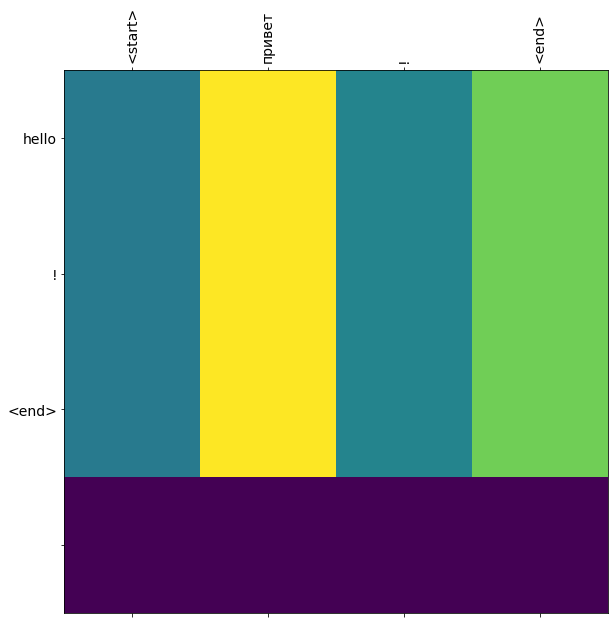

небо . 
the skies are his .



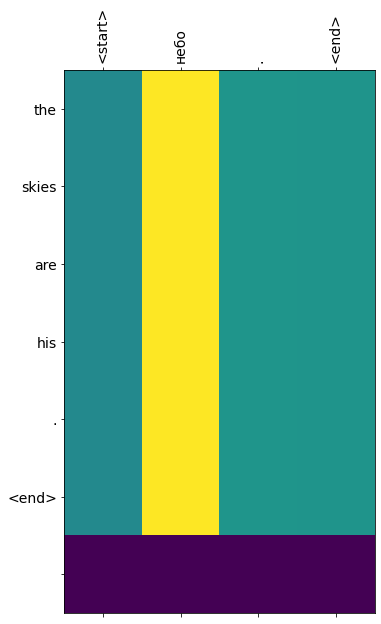

зеленое яблоко . 
the apple .



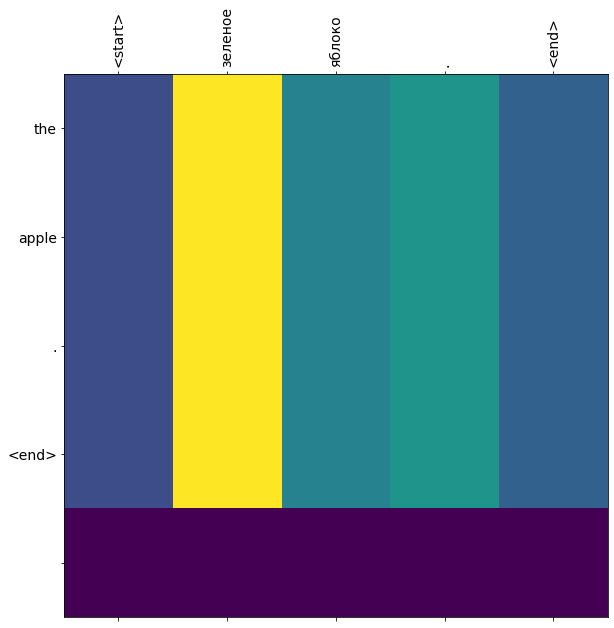

красивая газета . 
this is very strange .



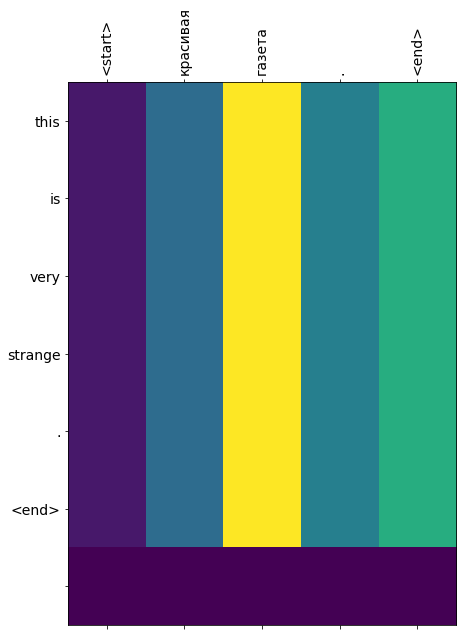

меня зовут юля . 
i'm dirty .



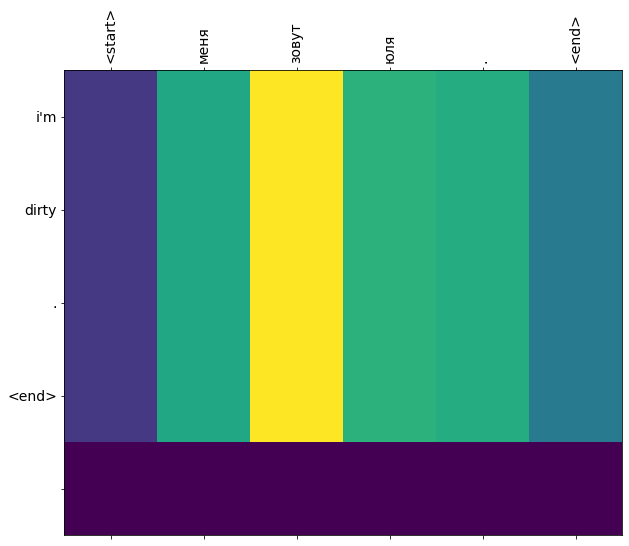

нужно взять ластик . 
you need to be clean up .



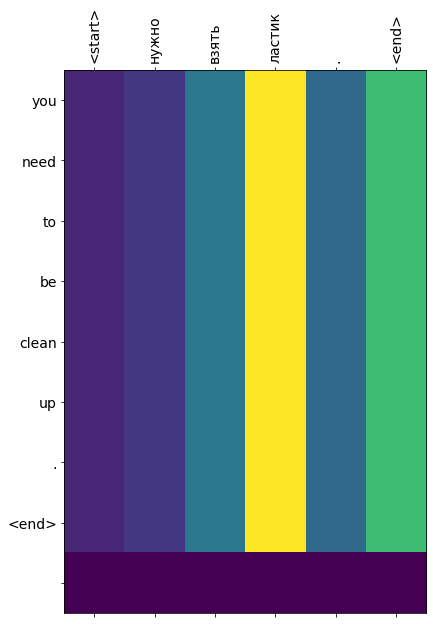

сегодня хорошая погода . 
it's fine today is fine today is fine today i



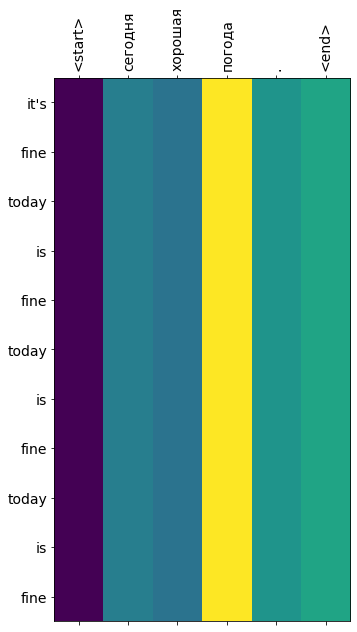

попробуй сделать это . 
try to do that .



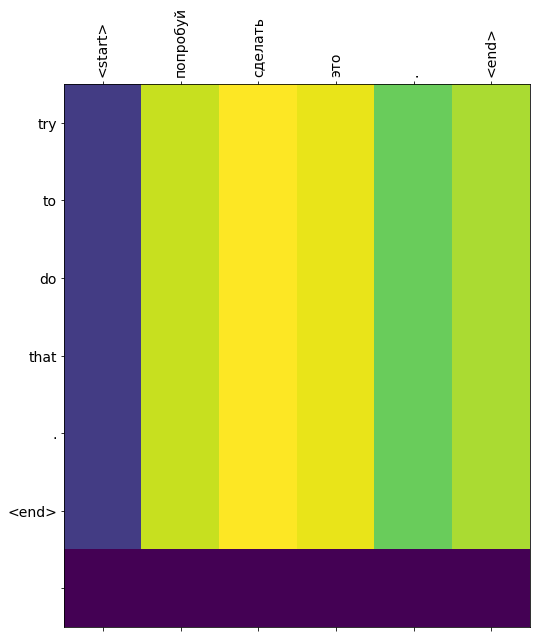

как проехать до аптеки ? 
how was the flight ?



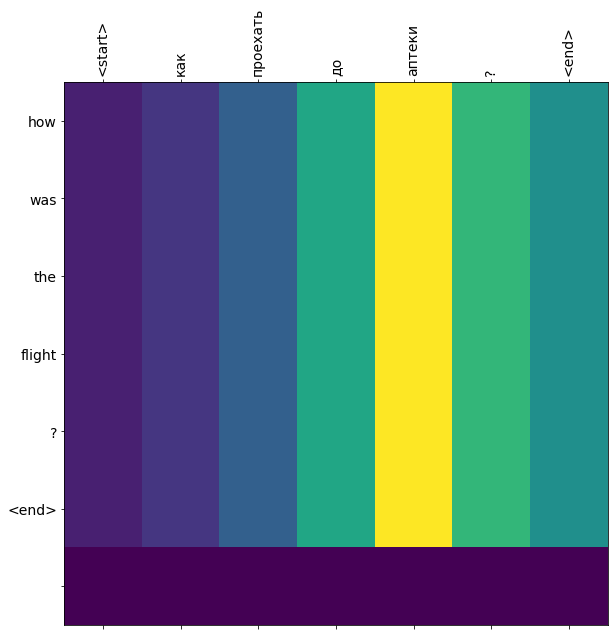

вы бывали в испании ? 
did you in a seat ?



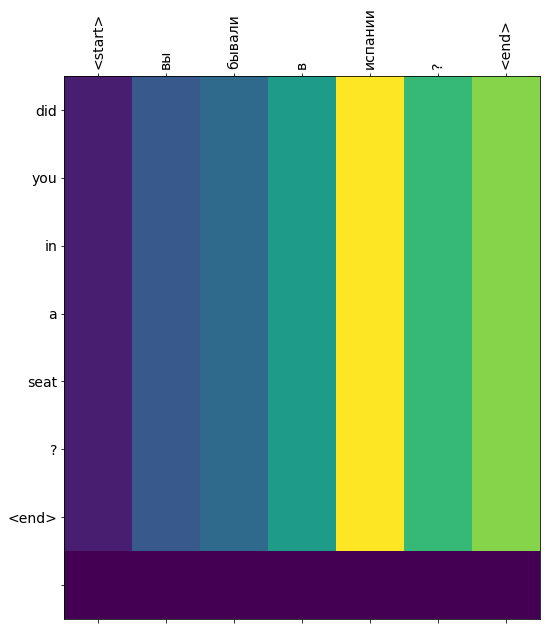

я люблю , когда идет снег . 
i like more .



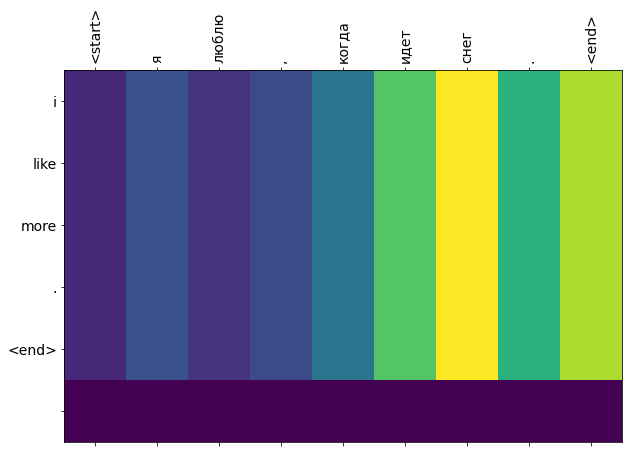

чтобы жить , нужно кушать . 
we need to eat .



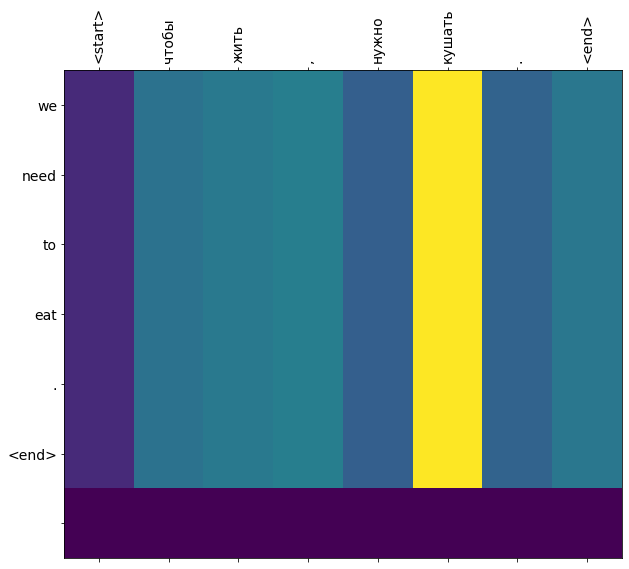

откуда у него велосипед ? 
how old was he ?



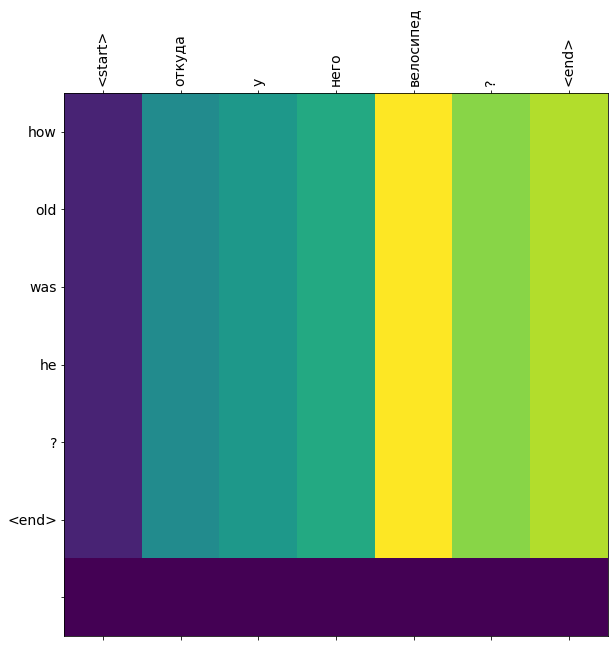

алеша , выходи поиграть в мяч ! 
play the pool ?



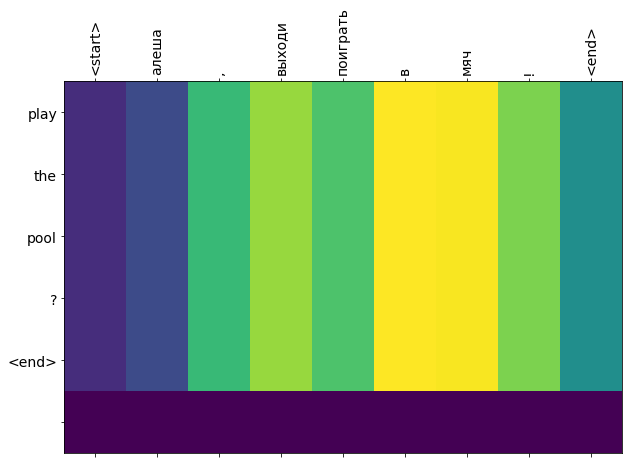

вы часто готовите сладкие булочки ? 
do you often ?



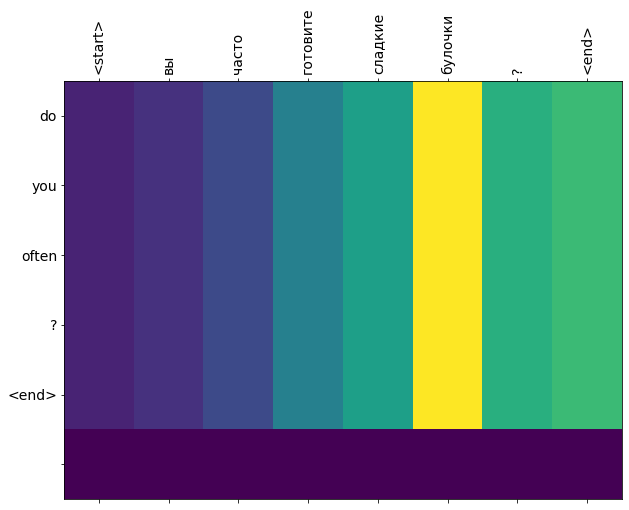

он сходил в магазин и купил молоко . 
he ran out the door .



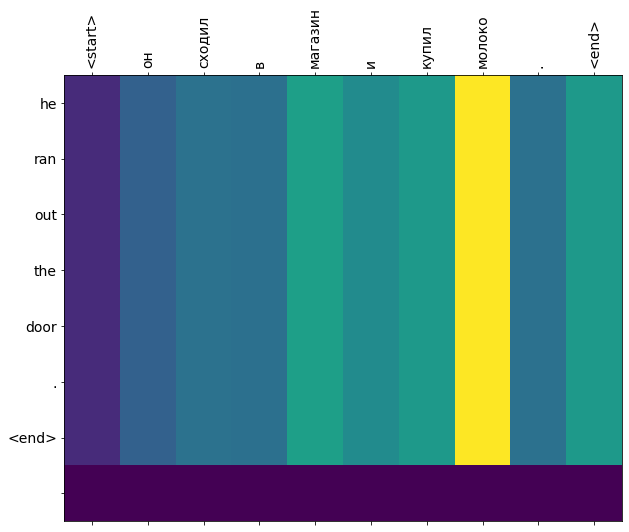

слово не воробей , вылетит не поймаешь 
don't catch me a word .



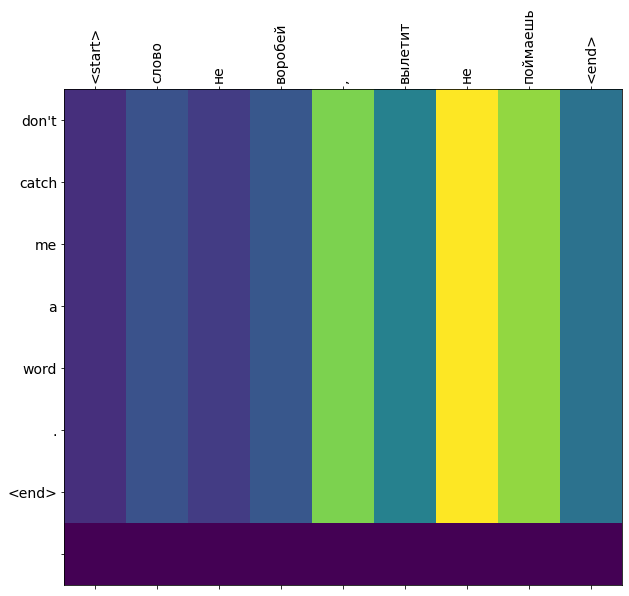

хочу провести следующий новый год за городом . 
i want a new kitchen .



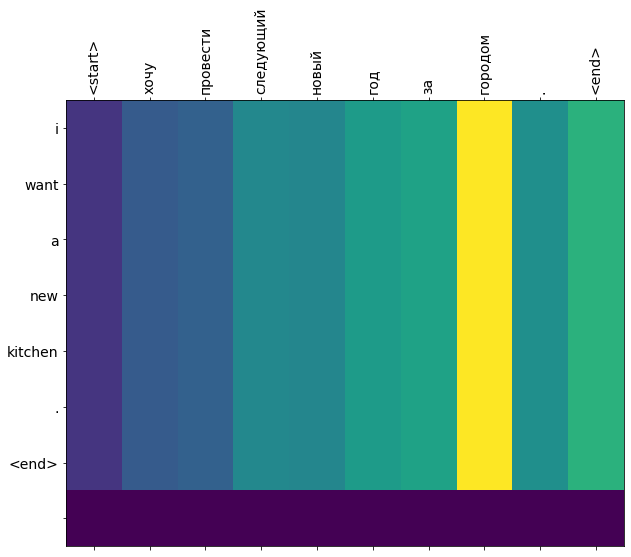

за окном бушует ураган , довольно опасно выходить на улицу . 
the window .



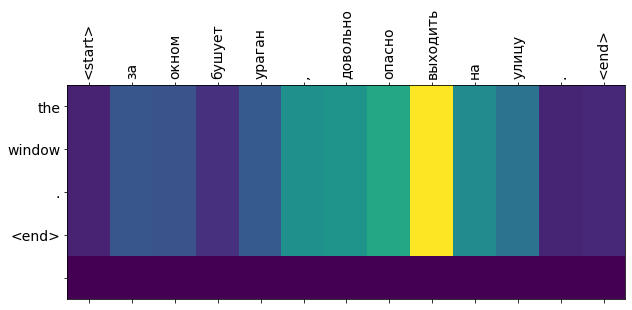

зачем некоторые люди употребляют алкоголь и потом смеются ? 
when more special ?



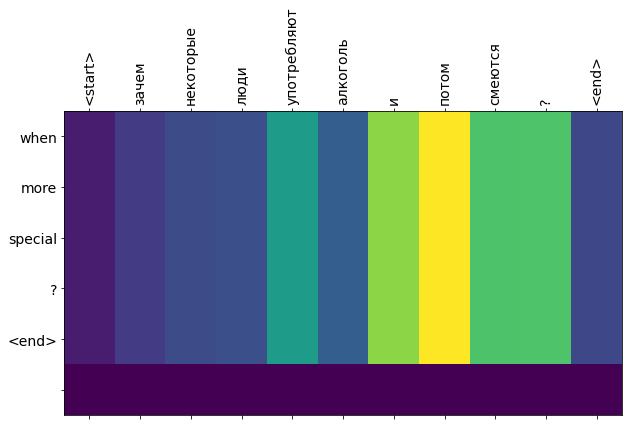

я люблю рисовать пастелью различные картины цветы , животных , пейзажи . 
i like ten .



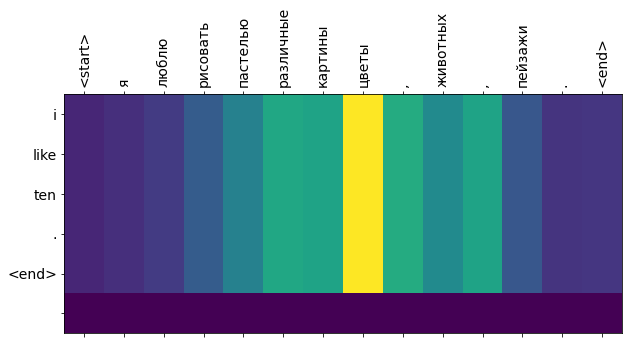

скоро я поеду в другой город смотреть на северное сияние и больших плавающих китов . 
i'll go home soon .



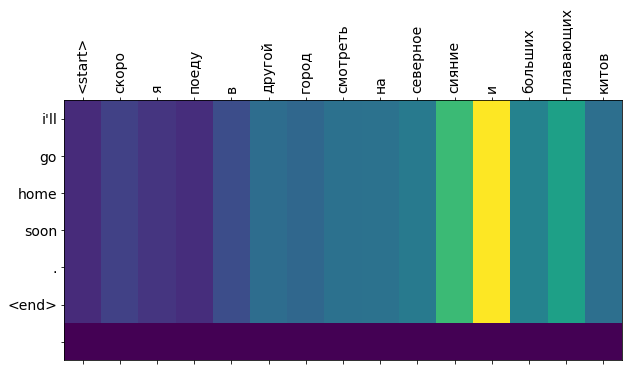

она каждое утро делает макияж , завтракает , едет на метро , чтобы снова работать в поте лица . 
actually , wait soon .



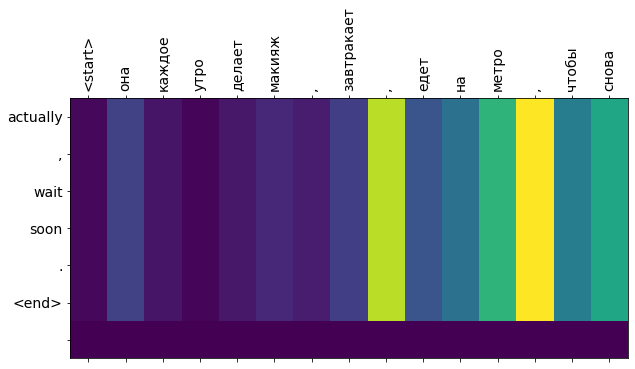

In [46]:
translate('Привет!')
translate('Небо.')
translate('Зеленое яблоко.')
translate('Красивая газета.')
translate('Меня зовут Юля.')
translate('Нужно взять ластик.')
translate('Сегодня хорошая погода.')
translate('Попробуй сделать это.')
translate('Как проехать до аптеки?')
translate('Вы бывали в Испании?')
translate('Я люблю, когда идет снег.')
translate('Чтобы жить, нужно кушать.')
translate('Откуда у него велосипед?')
translate('Алеша, выходи поиграть в мяч!')
translate('Вы часто готовите сладкие булочки?')
translate('Он сходил в магазин и купил молоко.')
translate('Слово не воробей, вылетит — не поймаешь')
translate('Хочу провести следующий Новый год за городом.')
translate('За окном бушует ураган, довольно опасно выходить на улицу.')
translate('Зачем некоторые люди употребляют алкоголь и потом смеются?')
translate('Я люблю рисовать пастелью различные картины: цветы, животных, пейзажи.')
translate('Скоро я поеду в другой город смотреть на северное сияние и больших плавающих китов.')
translate('Она каждое утро делает макияж, завтракает, едет на метро, чтобы снова работать в поте лица.')

In [ ]:
# привет ! 
# hi .
# hello !

# небо . 
# the sky is lying .
# the skies are his .

# зеленое яблоко . 
# the apple is an apple is an apple is an
# the apple .

# красивая газета . 
# this is pretty .
# this is very strange .

# меня зовут юля . 
# my name .
# i'm dirty .

# нужно взять ластик . 
# take a wild .
# you need to be clean up .

# сегодня хорошая погода . 
# the weather .
# it's fine today is fine today is fine today i

# попробуй сделать это . 
# try and make this .
# try to do that .

# как проехать до аптеки ? 
# how is the town ?
# how was the flight ?

# вы бывали в испании ? 
# were you in trying in trying in trying in try
# did you in a seat ?

# я люблю , когда идет снег . 
# i like snow .
# i like more .

# чтобы жить , нужно кушать . 
# to eat .
# we need to eat .

# откуда у него велосипед ? 
# what's mary's bicycle ?
# how old was he ?

# алеша , выходи поиграть в мяч ! 
# come playing at the keys .
# play the pool ?

# вы часто готовите сладкие булочки ? 
# do you bake often ?
# do you often ?

# он сходил в магазин и купил молоко . 
# he bought milk .
# he ran out the door .

# слово не воробей , вылетит не поймаешь 
# i wish not like to say no word didn't 
# don't catch me a word .

# хочу провести следующий новый год за городом . 
# i want a city .
# i want a new kitchen .

# за окном бушует ураган , довольно опасно выходить на улицу . 
# way is out .
# the window .

# зачем некоторые люди употребляют алкоголь и потом смеются ? 
# why would tom even do you lost over ?
# when more special ?

# я люблю рисовать пастелью различные картины цветы , животных , пейзажи . 
# i love my bet love my bet love my be
# i like ten .

# скоро я поеду в другой город смотреть на северное сияние и больших плавающих китов . 
# i'll be watching tv .
# i'll go home soon .

# она каждое утро делает макияж , завтракает , едет на метро , чтобы снова работать в поте лица . 
# life's barely get home .
# actually , wait soon .

**Из нововведений:**

1. Использование двунаправленного RNN в Энкодере.
2. Обработка случая, когда в словаре нет слова, которое нужно перевести. Слово проходит лемматизацию и снова осуществляется поиск по словарю, в противном случае слово не учитывается вообще.
3. Увеличено количество эпох до 60.

**Вывод:**

Машинный перевод с блоком внимания оказался еще хуже, чем без него. Длинные фразы также обрабатываются довольно плохо.

Из возможных экспериментов, можно попробовать увеличить словарь и количество эпох. Убрать двунаправленный RNN.

**Полезные ссылки:**

[Декоратор tf.function для ускорения выполнения функций](https://proproprogs.ru/tensorflow/tf-dekorator-tffunction-dlya-uskoreniya-vypolneniya-funkciy)

[Модель сохранения и восстановления TensorFlow](https://dzen.ru/media/machinelearning/model-sohraneniia-i-vosstanovleniia-tensorflow-5fe0aa6771b26f4593dfac95)